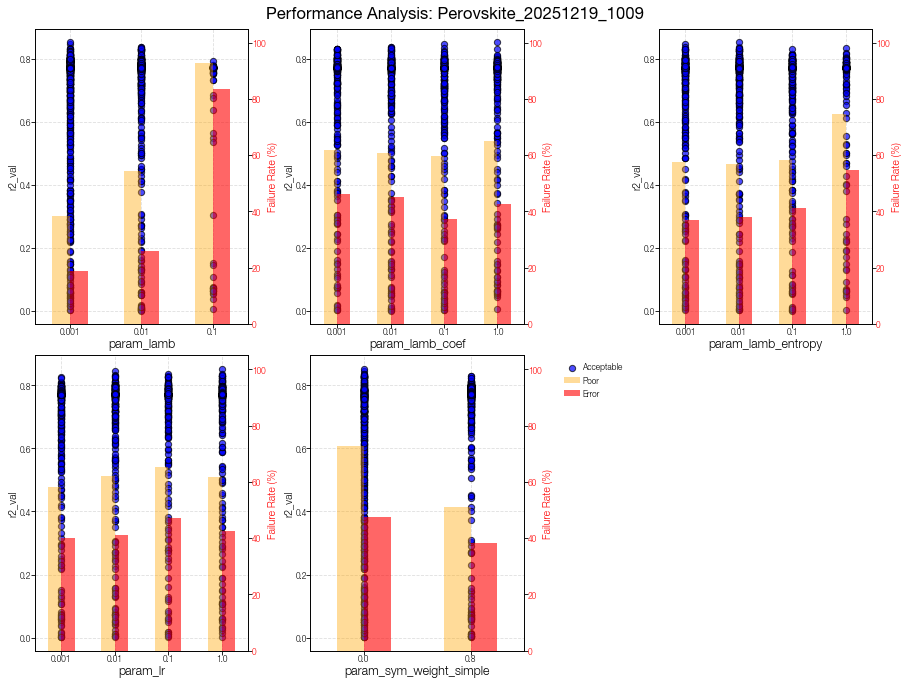

In [3]:
import pandas as pd
import os
from kan.experiments.multkan_hparam_sweep import plot_parameter_performance

root_dir = os.path.join(os.getcwd())
save_dir = os.path.join(root_dir, "custom_figures", "material_03")
os.makedirs(save_dir, exist_ok=True)

f_param = "Perovskite_20251219_1009"
save_heading = os.path.join(save_dir, f_param + "_analysis")
load_heading = os.path.join(root_dir, 'multkan_sweep_autosave', f_param)
plot_parameter_performance(f_param, os.path.join(root_dir, 'multkan_sweep_autosave'))

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from kan.custom_processing import remove_outliers_iqr
import torch
import os

filepath = os.path.join(root_dir, "data", "Perovskite.csv")
filedata = pd.read_csv(filepath)
name_X = filedata.columns[:-1].tolist()
name_y = filedata.columns[-1]
df_in = filedata[name_X]
df_out = filedata[[name_y]]
print(f"TARGET: {name_y}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df_in_final, df_out_final = remove_outliers_iqr(df_in, df_out)

removed_count = len(df_in) - len(df_in_final)
print(f"# of data after removing outliers: {len(df_in_final)} 개 ({removed_count} 개 제거됨)")

X = df_in_final[name_X].values
y = df_out_final[name_y].values.reshape(-1, 1)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2,
                                                  random_state=42)
print(f"Train set: {len(X_train)} ({len(X_train) / len(X) * 100:.1f}%)")
print(f"Validation set: {len(X_val)} ({len(X_val) / len(X) * 100:.1f}%)")
print(f"Test set: {len(X_test)} ({len(X_test) / len(X) * 100:.1f}%)")

feature_range = (0.1, 0.9)
scaler_X = MinMaxScaler(feature_range=feature_range)
scaler_y = MinMaxScaler(feature_range=feature_range)

X_train_norm = scaler_X.fit_transform(X_train)
y_train_norm = scaler_y.fit_transform(y_train)

X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)

y = df_out_final[name_y].values.reshape(-1, 1)

TARGET: Instability index
# of data after removing outliers: 139 개 (0 개 제거됨)
Train set: 88 (63.3%)
Validation set: 23 (16.5%)
Test set: 28 (20.1%)


{'grid': 30, 'grid_range': (0.1, 0.9), 'k': 3, 'lamb': 0.001, 'lamb_coef': 0.001, 'lamb_entropy': 0.001, 'lr': 0.01, 'mult_arity': 0, 'opt': 'LBFGS', 'prune': True, 'pruning_edge_th': 0.03, 'pruning_node_th': 0.01, 'steps': 50, 'sym_weight_simple': 0.8, 'symbolic': True, 'update_grid': True, 'width': '[[3, 0], [3, 0], [1, 0]]'}
tensor([0.2040, 0.7320, 0.1640])


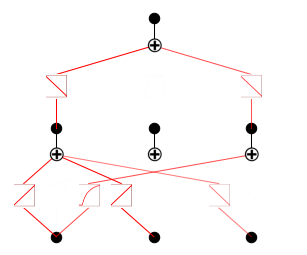

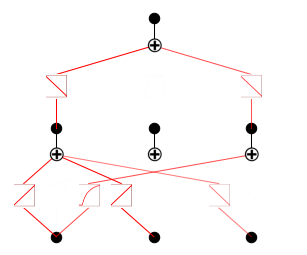

-0.3377*x_1 - 0.5997*x_2 + 0.1408*x_3 + 0.5758 + 0.0179/(-x_1 - 0.1821)**2

In [5]:
from kan.utils import ex_round
from kan.experiments.multkan_hparam_sweep import get_arg_dict, _seed_everything
from kan.custom_multkan_ddp import KAN
import matplotlib.pyplot as plt

d_opt = pd.read_excel(load_heading + ".xlsx", sheet_name='best_avg_by_params')
d_opt_flat = d_opt.iloc[0]
d_opt_flat = d_opt_flat.to_dict()

model = KAN.loadckpt(path=load_heading+"_model")
model.plot()

params = {k: v for k, v in d_opt_flat.items() if "param_" in k}
params = {key.replace('param_', ''): value for key, value in params.items()}
params['grid_range'] = feature_range
print(params)

_seed_everything(0)
device, model_kwargs, fit_kwargs, dataset = get_arg_dict((X_train_norm, y_train_norm, X_val_norm, y_val_norm, X_test_norm, y_test_norm, params, device.type, scaler_y, 0))
print(dataset['train_input'][0])
# fit_kwargs['steps'] = 100
# model.auto_symbolic(weight_simple=0, a_range=(-50,50), b_range=(-50,50))
# model.fit(dataset, **fit_kwargs)
model.plot()
plt.show()
ex_round(model.symbolic_formula()[0][0], 4)

{'train': 0.7344721529827927, 'test': 0.8617095069180013}


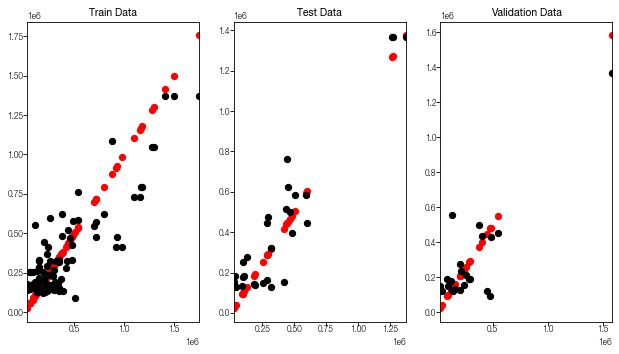

tensor([0.2040, 0.7320, 0.1640])


In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

y_pred_norm_test = model.forward(x=dataset['test_input']).detach().cpu().numpy()
y_pred_norm_train = model.forward(x=dataset['train_input']).detach().cpu().numpy()
y_pred_norm_val = model.forward(x=dataset['val_input']).detach().cpu().numpy()

y_pred_test = scaler_y.inverse_transform(y_pred_norm_test)
y_pred_train = scaler_y.inverse_transform(y_pred_norm_train)
y_pred_val = scaler_y.inverse_transform(y_pred_norm_val)
# y_train = dataset['train_label']
# y_test = dataset['test_label']

r2_score = {
    "train": r2_score(y_train, y_pred_train),
    "test": r2_score(y_test, y_pred_test),
}
print(r2_score)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax_train = ax[0]
ax_train.scatter(y_train, y_train, color='r')
ax_train.scatter(y_train, y_pred_train, color='k')
ax_train.set_title("Train Data")

ax_test = ax[1]
ax_test.scatter(y_test, y_test, color='r')
ax_test.scatter(y_test, y_pred_test, color='k')
ax_test.set_title("Test Data")

ax_test = ax[2]
ax_test.scatter(y_val, y_val, color='r')
ax_test.scatter(y_val, y_pred_val, color='k')
ax_test.set_title("Validation Data")

plt.show()
plt.show()

Text(0, 0.5, 'Attribution score')

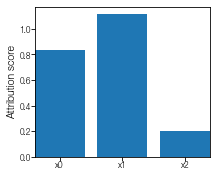

In [7]:
fig, ax = plt.subplots()
model.forward(dataset['train_input'])
scores_tot = model.feature_score
ax.bar([f"x{i}" for i in range(scores_tot.shape[0])], scores_tot.tolist())
# ax.set_xticks([f"x{i}" for i in range(score_L0.shape[0])])
ax.set_ylabel("Attribution score")

Layer 0 : in 0 -- out 0
Slope: [-0.039781101047992706, 0.007648006081581116, 0.009219065308570862, 0.04504271596670151, 0.0198558010160923, 0.08125093765556812, 0.0738272164016962]
[-1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Inflection point: 0.10000000149011612
Layer 0 : in 0 -- out 1
Slope: [0.2619672864675522, 0.2183229774236679, -0.0475887656211853, -0.3009418045403436, -0.1252512390492484, 0.1743948943912983, -0.14448586478829384]
[1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0]
Inflection point: 0.18160000443458557
Layer 0 : in 0 -- out 2
Slope: [0.07161612063646317, 0.08209146652370691, 0.010737492702901363, 0.013380346819758415, -0.01267261360771954, 0.02868465823121369, -0.2600018307566643]
[1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0]
Inflection point: None
Layer 0 : in 1 -- out 0
Slope: [-0.17513059079647064, -1.636892557144165e-05, 0.01572578400373459, -0.0055494047701358795, 0.02349291928112507, -0.05631622485816479, 1.6393719539046288]
[-1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0]
Inflection point: No

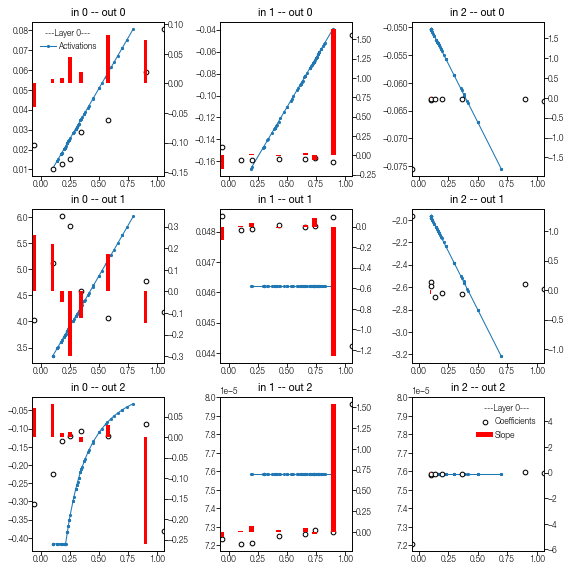

[[[tensor(0.1000), tensor(0.1816), None], [None, tensor(0.1000), tensor(0.1000)], [tensor(0.1378), None, None]]]


In [11]:
import numpy as np

def find_index_sign_revert(data_list, epsilon=5e-3):
    """
    Finds the first index where the sign changes and persists for
    more than one element.

    Values with absolute magnitude smaller than epsilon are treated as having the same sign as the previous element, effectively ignoring small fluctuations around zero.

    Args:
        data_list (list): A list of numbers.
        epsilon (float): The threshold below which a value is considered to have "no sign change" relative to the previous value.

    Returns:
        int or None: The first index of a persistent sign change,
                     or None if no such change is found.
    """
    if len(data_list) < 3:
        return None

    effective_signs = [np.sign(data_list[0])]

    for i in range(1, len(data_list)):
        val = data_list[i]
        prev_sign = effective_signs[-1]

        if abs(val) < epsilon:
            effective_signs.append(prev_sign)
        else:
            effective_signs.append(np.sign(val))
    print(effective_signs)

    # Now search for the persistent sign change using these cleaned signs
    for i in range(1, len(effective_signs) - 1):
        if effective_signs[i] != effective_signs[i-1]:
            if effective_signs[i+1] == effective_signs[i]:
                return i

    return None

depth = len(model.act_fun)
layers_to_plot = [0]
inflection_points = []

for l in layers_to_plot:
    act = model.act_fun[l]
    ni, no = act.coef.shape[:2]
    coef = act.coef.tolist()
    inflection_points_per_layer = []

    fig, axs = plt.subplots(nrows=no, ncols=ni, squeeze=False,
                            figsize=(max(2.5*ni, 6), max(2.5*no, 3.5)),
                            constrained_layout=True)
    second_axs = np.zeros_like(axs)
    for i in range(ni):
        inflection_points_per_input = []
        for j in range(no):
            ax = axs[j, i]
            # Gather pre- and post-activations and sort by input
            inputs = model.spline_preacts[l][:, j, i].cpu().detach().numpy()
            outputs = model.spline_postacts[l][:, j, i].cpu().detach().numpy()
            output_spline = model.spline_postsplines[l][:, j, i].cpu().detach().numpy() # without base function values
            coef_node = coef[i][j]
            num_knot = act.grid.shape[1]
            spline_radius = int((num_knot - len(coef_node)) / 2)
            bar_width = min(act.grid[i, 1:] - act.grid[i, :-1]) / 2

            rank = np.argsort(inputs)
            ax.plot(inputs[rank], outputs[rank], marker='o', ms=2, lw=1, label='Activations')
            # ax.plot(inputs[rank], output_spline[rank], marker='^', ms=1, lw=1, label='Splines Only')

            ax2 = ax.twinx()
            second_axs[j, i] = ax2
            ax2.scatter(act.grid[i, spline_radius:-spline_radius], coef_node,
                       s=20, color='white', edgecolor='k', label='Coefficients')
            slope = [x - y for x, y in zip(coef_node[1:], coef_node[:-1])]
            slope_2nd = [(x - y)*10 for x, y in zip(slope[1:], slope[:-1])]
            bars = ax2.bar(act.grid[i, spline_radius:-(spline_radius + 1)], slope,
                    width=bar_width, align='center', color='r', label='Slope')
            ax.set_title(f'in {i} -- out {j}', fontsize=10)

            print(f'Layer {l} : in {i} -- out {j}')
            print(f'Slope: {slope}')

            idx_revert = find_index_sign_revert(slope)
            if idx_revert is None:
                inflection_val = None
            else:
                inflection_val = act.grid[i, spline_radius + idx_revert]
            inflection_points_per_input.append(inflection_val)

            print(f'Inflection point: {inflection_val}')
        inflection_points_per_layer.append(inflection_points_per_input)
    axs[0, 0].legend(loc='best', fontsize=8, title=f'---Layer {l}---', title_fontsize=8)
    second_axs[-1, -1].legend(loc='best', fontsize=8, title=f'---Layer {l}---', title_fontsize=8)
    inflection_points.append(inflection_points_per_layer)

    plt.show()
print(inflection_points)

[0.1, tensor(0.1378), 0.9]
[tensor(13), tensor(51)]


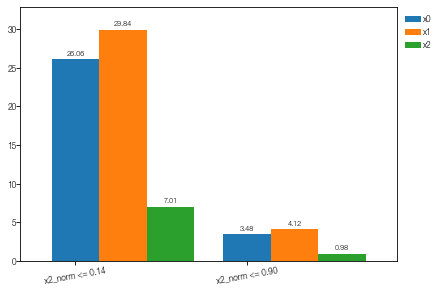

In [16]:
mask_idx = 2
mask_interval = [0.1] + [ip for ip in inflection_points[0][mask_idx] if ip is not None] + [0.9]
print(mask_interval)

x_mask = dataset['train_input'][:, mask_idx]
y_vals = dataset['train_label'].ravel()

masks = [ ((x_mask > lb) & (x_mask <= ub)) for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
labels = [f'x{mask_idx}_norm <= {ub:.2f}' for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
print([sum(x) for x in masks])

scores_interval = []
scores_interval_norm = []
for mask in masks:
    if np.any(mask.numpy()):
        x_tensor_masked = dataset['train_input'][mask, :]
        x_std = torch.std(x_tensor_masked, dim=0).detach().cpu().numpy()
        model.forward(x_tensor_masked)

        score_masked = model.feature_score.detach().cpu().numpy()
        score_norm = score_masked / x_std
        scores_interval.append(score_masked)
        scores_interval_norm.append(score_norm)
    else:
        scores_interval.append(np.zeros(scores_tot.shape))
        scores_interval_norm.append(np.zeros(scores_tot.shape))

width = 0.25
fig, ax = plt.subplots(figsize=(6,4))
xticks = np.arange(len(masks)) * (width * scores_tot.shape[0] * 1.2)
xticklabels = labels
max_score = max([max(s) for s in scores_interval_norm])
for idx in range(scores_tot.shape[0]):
    bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval_norm], width, label=f"x{idx}")
    ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax.margins(x=0.1)
ax.set_ylim(0, max_score * 1.1)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.tight_layout()
plt.show()